# Lab  6

## Objectives:  

Implement strategies for

* large scale optimization: cooperative coevolution
* multi-objective optimization: aggregation vs. nondominance approaches
* multi-modal optimization: crowding strategy

Base evolutionary algorithm:  Differential Evolution



In [35]:
#single-objective continuous optimization problems
import numpy as np

class ContinuousOptimization:
    """
    find the minimum of an objective function
    """
    def __init__(self, n, lowerBound, upperBound, fct_name):
        """
        Constructor
        :param N - problem size
        :param lowerBound - lower bound of the domain
        :param upperBound - upper bound of the domain
        :param eval_fct - function name as string
        """
        self.N = n
        self.lowerBound = lowerBound
        self.upperBound = upperBound
        self.eval_fct = fct_name
        
    def generate_random_elem(self):
        """
        Generate a vector of N real numbers randomly generated in [lowerBound, upperBound]
        """
        return self.lowerBound+np.random.random(self.N)*(self.upperBound-self.lowerBound)
 
    # repairing function (values outside [a,b] are replaced by random values in [a,b])
    def repair(self, element):
        for k in range(len(element)):
            if element[k]<self.lowerBound or element[k]>self.upperBound:
                    element[k] = self.lowerBound+np.random.rand()*(self.upperBound-self.lowerBound)

    def eval(self, element):
        """
        :param element - the element which will be evaluated
        """
        return getattr(self, self.eval_fct)(element)
    
    def evalSphere(self, element):
        """
        Evaluation: Sphere function
        :param element - a population element
        """
        s = 0
        for x in element:
            s += x*x
        return s
        #return np.sum(element*element)
    
    def evalAckley(self, element):
        sp=0
        sc=0
        d=len(element)
        for x in element:
            sp += x**2
            sc += np.cos(2*np.pi*x)      
        term1 = -20 * np.exp(-0.2 * ((1.0/d) * (sp **0.5) ))
        term2 = np.exp((1.0/d)*sc)
      
        return term1-term2 + 20 + np.exp(1)
    
    def evalGriewank (self, element):
        s = 0
        p = 1
        count = 1 
        for x in element:
           s = s + x ** 2
           p = p * np.cos( x / np.sqrt(count))  
        count += 1   
        return s/4000. - p + 1



In [83]:
## display population in 2D case
def FunctionPlot(prob, points, start=-2, stop=2):
    x = np.linspace(start,stop,2500)
    y = np.linspace(start,stop,2500)
    X, Y = np.meshgrid(x, y)
    Z=[]
    #print(Z)
    Z=prob.eval([X, Y])
   
    %matplotlib inline
    import matplotlib.pyplot as plt
    #plt.style.use('seaborn-white')
    from mpl_toolkits import mplot3d

    fig = plt.figure(figsize = (20,10))
    grid_y = 5
    grid_x = len(points) // grid_y + 1
    k=0
    N=len(points)
    for t in points:
        print("rendering figure {} of {}".format(k, N))
        #Contour plot
        ax = fig.add_subplot(grid_x, grid_y, k+1)
        ax.contour(X,Y,Z, 50, colors = 'gray') #cmap = 'RdPu_r')
        n= len(t[0])
        ax.scatter([t[0][i][0] for i in range(n)], [t[0][i][1] for i in range(n)],color = 'r', marker = '*')
        ax.scatter(t[1][0],t[1][1],color = 'r', marker = '*')
        ax.set_title(t[2])
        
        k += 1          
    plt.show()
    
#FunctionPlot(c_prob, graficPoints, start=-5, stop=5)


### Differential Evolution

(reminder Lab 5)

DE is a popular optimization technique based on a simple rule of constructing new candidates by using differences between elements of the current population. The basic idea is to construct for each population element x(i) a new trial element following the steps:
*	Construct a “mutant” vector, $y$, by combining several elements of the population. Two of the most used approaches are:
 * DE/rand/1/bin:  $y=x(r1)+F*(x(r2)-x(r3))$  where  $r1,r2,r3$ are distinct random indices
 * DE/best/1/bin:  $y=x(ibest)+F*(x(r2)-x(r3))$ where $x(ibest)$ is the best element of the population 
Rmk: in both cases, $F$ is a scale factor taking values in $(0,2)$.
*	Construct a trial element, $z$, by crossing over the components of the mutant $y$ with  those of the current element, $x(i)$,  by following the rule (known as binomial crossover):
 *	$z(j)=y(j)$  with probability $CR$
 *	$z(j)=x(i,j)$ with probability $1-CR$
 
Rmk: $CR$ (with values in $(0,1)$) is a crossover probability.

 

In [46]:
def populationGraphic(population, globalBest, msg):
    pointsVector = [el.x.copy() for el in population]   
    return [pointsVector, globalBest.x.copy(), msg]

In [71]:
#alg DE
class Element:
    def __init__(self, x):
        self.x=x
        self.cost=0
        
        
    def copy(self):
        new_el = Element(self.x.copy())
        new_el.cost = self.cost
        return new_el
    
    def update(self, el, cost):
        self.x=el.copy()
        self.cost=cost
        
    def __repr__(self):
        return "cost: {} element: {}".format(self.cost, self.x)
  
def DE_Rand1Bin(el, population, F, CR):
    """
    Differential Evolution: construction of a new element
    Step 1:  Mutation:  trialVector=pop(r1)+F*(pop(r2)-pop(r3))
    Step 2:  Crossover: trialVector(j)=pop(i,j) with probability 1-CR (CR is similar with mutation probability)
    """
    m = len(population) #population size
    n = len(el.x) #problem size
    trialVector = np.zeros(n);
    r1 = np.random.randint(low=0, high=m)
    r2 = np.random.randint(low=0, high=m) 
    while r2 == r1:
        r2 = np.random.randint(low=0, high=m)
        
    r3 = np.random.randint(low=0, high=m)
    while (r3==r1) or (r3==r2):
        r3 = np.random.randint(low=0, high=m)
       
    trialVector=population[r1].x+F*(population[r2].x-population[r3].x)  # selectare indice parinte
    for j in range(n):
        u = np.random.rand()
        if u<1-CR: 
            trialVector[j] = el.x[j]
    return  trialVector
   

def DE_Best1Bin(el, population, globalBest, F, CR):
    """
    Differential Evolution: construction of a new element
    Step 1: Mutation:   trialVector=pop(ibest)+F*(pop(r2)-pop(r3))
    Step 2: Crossover: trialVector(j)=pop(i,j) with probability 1-CR (CR is similar with mutation probability)
    """
    m = len(population) #population size
    n = len(el.x) #problem size
    trialVector = np.zeros(n);
    r1 = np.random.randint(low=0, high=m)
    r2 = np.random.randint(low=0, high=m) 
    while r2 == r1:
        r2 = np.random.randint(low=0, high=m)
        
    trialVector=globalBest.x+F*(population[r1].x-population[r2].x)  # selectare indice parinte
    for j in range(n):
        u = np.random.rand()
        if u<1-CR: 
            trialVector[j] = el.x[j]
    return  trialVector


    
def DE(prob, popSize, genNo,F,CR):
    """
    :param prob - the problem to be solved (test function)
    :param popSize -  population size
    :param genNo - number of generations 
    :param F - scale factor
    :param CR - crossover probability
    """
    #populationInitialization
    population = [Element(prob.generate_random_elem()) for i in range(popSize)]
    #populationEvaluation
    for el in population: 
        el.cost  = prob.eval(el.x)
        
    globalBest = min(population, key=lambda x: x.cost).copy()  # for a minimization problem

    graphicPoints = [populationGraphic(population, globalBest, "initial population")]

    for it in range(1,genNo+1):
        for el in population:
            new_el = DE_Rand1Bin(el, population, F, CR)
            #new_el = DE_Best1Bin(el, population, globalBest, F, CR)
            prob.repair(new_el)
            new_el_cost = prob.eval(new_el)
            
            if new_el_cost < el.cost:
                #print(population)
                #print(new_el, new_el_cost)
                el.update(new_el, new_el_cost)
        globalBest = min(population, key=lambda x: x.cost).copy()
        #print("at iteration {} best el cost is {}".format(it, globalBest.cost))
        
        if it % 25 == 0:
            graphicPoints.append(populationGraphic(population, globalBest, "population at it {}".format(it)))
        
    graphicPoints.append(populationGraphic(population, globalBest, "final population"))
    return globalBest.cost, globalBest.x, graphicPoints
        

at iteration 1 best el cost is 2898.881323758736
at iteration 2 best el cost is 2898.881323758736
at iteration 3 best el cost is 2898.881323758736
at iteration 4 best el cost is 2868.765663111951
at iteration 5 best el cost is 2868.765663111951
at iteration 6 best el cost is 2868.765663111951
at iteration 7 best el cost is 2868.765663111951
at iteration 8 best el cost is 2868.765663111951
at iteration 9 best el cost is 2863.8337294684866
at iteration 10 best el cost is 2863.8337294684866
at iteration 11 best el cost is 2863.8337294684866
at iteration 12 best el cost is 2438.2979059898166
at iteration 13 best el cost is 2438.2979059898166
at iteration 14 best el cost is 2438.2979059898166
at iteration 15 best el cost is 2438.2979059898166
at iteration 16 best el cost is 2438.2979059898166
at iteration 17 best el cost is 2438.2979059898166
at iteration 18 best el cost is 2438.2979059898166
at iteration 19 best el cost is 2275.2370895267213
at iteration 20 best el cost is 2275.23708952672

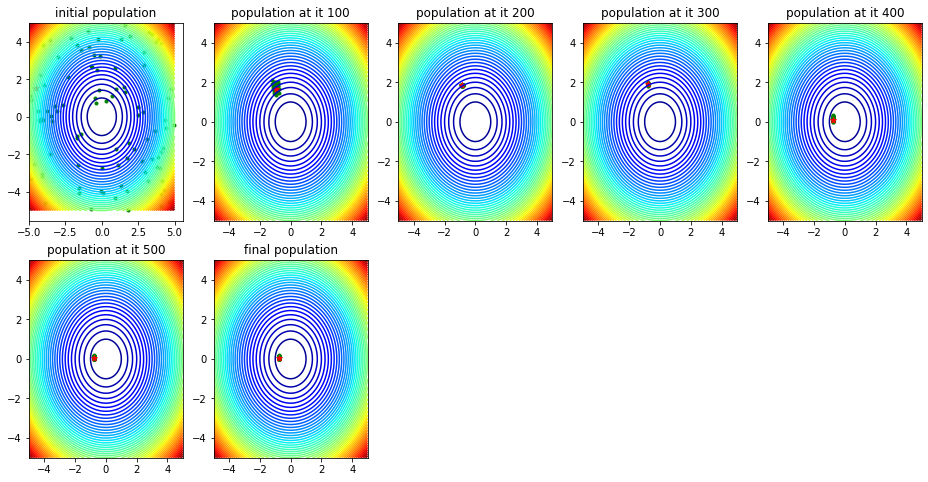

In [30]:
c_prob = ContinuousOptimization(500, -5,5, "evalSphere")
cost, el, graficPoints = DE(c_prob,100,500,0.5,0.5)
FunctionPlot(c_prob, graficPoints, start=-5, stop=5)

###  Large scale optimization - Cooperative Coevolution.

In the case of high dimensional optimization problems (e.g. more than 100 variables) the effectiveness of evolutionary algorithms might decrease significantly. One idea to address this issue is to decompose the original problem in several subproblems of smaller sizes. One approach exploiting this idea is cooperative coevolution which consists of:

* The $n$ design variables are grouped in $k<n$ components: $C_1,C_2,\ldots,C_k$; the ideal case would be that the correlated components are included in the same group; in practice it is difficult to identify the correlation pattern between variables, thus if this knowledge is not available one can apply an arbitrary assignment of variables to groups (components).

* For each component one applies a metaheuristic algorithm (it is interpreted that each component defines o lower dimensional problem) on the corresponding (sub)elements (a subelement consists of the variables belonging to the component). However to evaluate the quality of an element corresponding to a subcomponent, one need to know values also for the variables which do not belong to the component, i.e. it is necessary to know the context in which a subelement has to be evaluated. There are different ways to construct the context:

 * by using the corresponding variables of the best element in the population 
 * by using the corresponding variables of the current element in the population (that containing the evaluated subelement)
 * by using the corresponding variables of an arbitrary element of the population (randomly selected)
 
**Obs.**

* The evolutionary algorithm can be applied on each component for one or several iterations
* The strategy to apply the evolutionary algorithms can be synchronous (the context is constructed using the elements of the previous generation) or asynchronous (as soon as a new element is constructed it is incorporated into the population).


#### Example
Implement Cooperative Coevolution for the DE algorithm and compare its performance with that of traditional DE for optimization problems with $100$, $500$ and $1000$ variables.

In [17]:
def CC_DE_Best1Bin(el, population, globalBest, F, CR, startIndex, stopIndex):
    """
    Differential Evolution: construction of a new element
    Step 1: Mutation:   trialVector=pop(ibest)+F*(pop(r2)-pop(r3))
    Step 2: Crossover: trialVector(j)=pop(i,j) with probability 1-CR (CR is similar with mutation probability)
    
    Cooperative coevolution approach: 
     - the element is split in sub-elements specified by a startIndex and a stopIndex
     - to evaluate a "sub-element" the collaborating components are taken from the current element in the population
    """
    m = len(population) #population size
    n = len(el.x) #problem size
    trialVector = el.x.copy()
    r1 = np.random.randint(low=0, high=m)
    r2 = np.random.randint(low=0, high=m) 
    while r2 == r1:
        r2 = np.random.randint(low=0, high=m)
    
    for index in range(startIndex, stopIndex):
        trialVector[index]=globalBest.x[index]+F*(population[r1].x[index]-population[r2].x[index])  # selectare indice parinte
    for j in range(startIndex, stopIndex):
        u = np.random.rand()
        if u<1-CR: 
            trialVector[j] = el.x[j]
    return  trialVector

def CC_DE(prob, swarmSize, swarmNumber, genNo,F,CR):
    """
    :param prob - the problem to be solved
    :param popSize -  population size
    :param genNo - number of generations 
    :param F - scale factor
    :param CR - mutation probability
    """
    #populationInitialization
    population = []
    globalBest = []
    for k in range(swarmNumber):
        swarm = [Element(prob.generate_random_elem()) for i in range(swarmSize)]
        #populationEvaluation
        for el in swarm: 
            el.cost  = prob.eval(el.x)
        population.append(swarm)
        globalBestSwarm = min(swarm, key=lambda x: x.cost).copy()  # for a minimization problem
        globalBest.append(globalBestSwarm)
    print("Nr of DE elements (total population size):", swarmNumber*swarmSize)

    #graficPoints = [populationGraphic(population, globalBest, "initial population")]
    SD = prob.N//swarmNumber #number of variables in each subelement
    for it in range(1,genNo+1):
        #construct best element from all swarms
        best_combined = np.zeros(prob.N)
        for z in range(swarmNumber):
            for y in range(SD):
                best_combined[y+z*SD] = globalBest[z].x[y+z*SD]
        print(prob.eval(best_combined))
        for currSwarm in range(swarmNumber):
            # construct the context for the elements in the (sub)population corresponding to the current component
            for el in population[currSwarm]:
                for z in range(swarmNumber):
                    if z!= currSwarm:
                        for y in range(SD):
                            el.x[y+z*SD] = best_combined[y+z*SD]
                el.cost = prob.eval(el.x)
            #DE part
            for el in population[currSwarm]:
                new_el = CC_DE_Best1Bin(el, population[currSwarm], globalBest[currSwarm], F, CR, currSwarm*SD, (currSwarm+1)*SD)
                # idea: to include an adaptive context - currently it is the initial one
                new_el_cost = prob.eval(new_el)
                if new_el_cost < el.cost:
                    #print(population)
                    #print(new_el, new_el_cost)
                    el.update(new_el, new_el_cost)
            globalBest[currSwarm] = min(population[currSwarm], key=lambda x: x.cost).copy()
            
            #print("it", it,"dupa DE ", currSwarm)
            #for el in population[currSwarm]: print(el)
    
    #construct best element from all swarms
    best_combined = np.zeros(prob.N)
    for z in range(swarmNumber):
        for y in range(SD):
            best_combined[y+z*SD] = globalBest[z].x[y+z*SD]
    #graficPoints.append(populationGraphic(population, globalBest, "final population"))
    return prob.eval(best_combined), best_combined

dim_prob = 500
c_prob = ContinuousOptimization(dim_prob, -5,5, "evalSphere")
#CC_DE(prob, swarmSize, swarmNumber, genNo,F,CR)
cost, el = CC_DE(prob=c_prob,swarmSize=10,swarmNumber=50,genNo=500,F=0.5,CR=0.5)
print("cost", cost,"el", el)



Nr of DE elements (total population size): 500
4089.9984719086046
2241.4018025631844
1812.132459603356
1463.3223975765295
1256.8501565914034
1014.1870546930576
875.6434571302593
658.9025465399952
530.3584007332624
428.92183096860595
373.8119314454569
315.8419282517337
275.55098831995133
227.4467799882273
196.3859585733724
171.1683168489343
153.55244984676747
134.91534903233517
125.05852727318043
111.32667379156628
101.84150825712163
92.11561514274916
84.59321240418915
77.61031102443977
72.938910323325
70.28223143969254
66.10196421273709
63.25523252705725
61.09383943911153
59.10453334489298
56.72345307185713
54.56251083039141
52.90507273360522
51.55857173826944
50.2869473131235
49.0600728746978
47.56848635346785
46.45424391235887
45.30220075069802
43.62369506025612
42.38992478737847
41.56511175391134
40.43437497892644
39.386135848179464
38.33445809580591
37.231759896097834
36.23289687880592
34.965667666317806
33.941563528141124
33.31017116045357
32.701215497816555
32.20198835204912
31.6

### Multiobjective optimization


Multiobjective optimization means to simultaneously optimize several objective functions (criteria). The function to be optimized is vectorial $F:R^n\to R^r$, and its components can be denoted
as follows $F=(f_1,f_2,\ldots,f_r)$. The optimization criteria are usually conflicting, therefore the problem does not have an unique solution. In such a case we are looking for some trade-off solutions (called Pareto optimal) characterized by the fact that they cannot be improved with respect to all their components (any
improvement with respect to one criterion leads to a decrease of quality with respect to other criteria). 
There are different approaches of this problem. The main approaches are:

* ''Aggregation methods'': the multiobjective problem is transformed in an one-objective optimization problem by combining all optimization criteria in a single one. Thus the new objective function becomes: $f(x)=w_1f_1(x)+w_2f_2(x)+\ldots +w_rf_r(x)$ where $w_1$,$w_2$, $\ldots$, $w_r$ are weights associated to objective functions. For each set of weights one can obtain a different solution.
* ''Direct approximation of the Pareto optimal set'': it uses a population of elements which will approximate the Pareto optimal set. The approximation process can be an evolutionary one. The main difference between multiobjective EAs and single objective EAs is related with the selection process. In the MOEAs the selection process is based on the dominance relationship between the elements (see Lecture 10).
	
Examples of test functions used to evaluate the performance of multiobjective algorithms are available at: http://en.wikipedia.org/wiki/Test_functions_for_optimization or at http://people.ee.ethz.ch/~sop/download/supplementary/testproblems/ 



Example. Let us consider the function $F:[0,4]\to R\times R$, $F(x)=((x-1)^2,(x-2)^2)$. 
(a) Estimate the optimal Pareto set and the corresponding Pareto front by using the aggregation technique. 
(b) Plot the Pareto set (the points having as coordinates  the values of the objective functions computed at the previous step).  

Hint: The aggregated objective function is defined as $f(x)=w\cdot (x-1)^2+(1-w)\cdot (x-2)^2$;
To estimate the Pareto optimal set one can apply an evolution strategy (for instance, that described in SE.sci) or Particle Swarm Optimization, or Differential Evolution (see lab 5) to optimize the aggregated objective for the following values of w:  $(0,0.1,0.2,0.3,\ldots,0.9,1)$.  The corresponding results should be collected in a list



In [41]:
class MulticriterialOptimization:
    """
    - minimization with respect to all objective functions (optimization criteria)
    - bi-objective case (two objective functions)
    - aggregation method
    """
    def __init__(self, eval_fct, N, lowerBound, upperBound, w):
        """
        Constructor
        :param N - problem size
        :param lowerBound - lower bound of the domain
        :param upperBound - upper bound of the domain
        :param w - weight corresponding to the first objective function
        """
        self.N = N
        self.lowerBound = lowerBound
        self.upperBound = upperBound
        self.eval_fct = eval_fct
        self.w = w
        
    def generate_random_elem(self):
        """
        Generate a real numbers uniformly distributed in [lowerBound, upperBound]
        """
        return self.lowerBound+np.random.random(self.N)*(self.upperBound-self.lowerBound) #list with one element
 
    def repair(self, element):
        for k in range(len(element)):
            if element[k]<self.lowerBound or element[k]>self.upperBound:
                    element[k] = self.lowerBound+np.random.rand()*(self.upperBound-self.lowerBound)

    def eval(self, element):
        """
        :param element - the element which will be evaluated
        """
        return getattr(self, self.eval_fct)(element)
    
    def evalAggregated(self, element):
        """
        :param element - the element which will be evaluated
        """
        return self.w*self.f1(element)+(1-self.w)*self.f2(element)
    # Simple test problem: f1(x)=(x-1)*(x-1), f2(x)=(x-2)*(x-2)
    def f1(self, element):
        return np.sum((element-1)**2)
    
    def f2(self, element):
        return np.sum((element-2)**2)
# check if fx and fy are reciprocally non-dominated
# dominance = True if fx and fy are reciprocally non-dominated
# dominance = False if fx dominates fy or fy dominates fx
def dominance(fx,fy):
    xDomY = True
    # fx dominates fy?
    for i in range(len(fx)):
        if fx[i] > fy[i]:
            xDomY = False
    yDomX = True
    # fy dominates fx?
    for i in range(len(fx)):
        if fy[i] > fx[i]:
            yDomX = False        
    if (xDomY==False) and (yDomX==False):
        return True
    else:
        return False
    
def ParetoFrontConstruction(paretoSet):
    %matplotlib inline
    import matplotlib.pyplot as plt
    ParetoFrontAbscissa=[]
    ParetoFrontOrdin=[]
    m=len(paretoSet)
    for i in range(m):
        for j in range(i+1,m):
            x=paretoSet[i]
            y=paretoSet[j]
            fx=[mo.f1(x),mo.f2(x)]
            fy=[mo.f1(y),mo.f2(y)]
            if x != y and dominance(fx,fy):
                ParetoFrontAbscissa.append(mo.f1(x))
                ParetoFrontOrdin.append(mo.f2(x))
                ParetoFrontAbscissa.append(mo.f1(y))
                ParetoFrontOrdin.append(mo.f2(y))
    plt.scatter(ParetoFrontAbscissa,ParetoFrontOrdin)

0.15999999999999998 [1.8]
[array([1.9]), array([1.8]), array([1.7]), array([1.6]), array([1.5]), array([1.4]), array([1.3]), array([1.2]), array([1.1])]


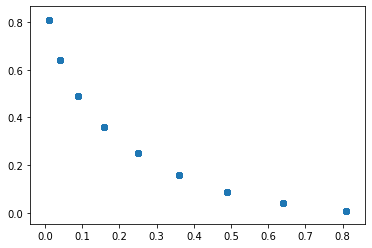

In [42]:
# definition of the problem (aggregated approach) -> one solution
mo = MulticriterialOptimization( "evalAggregated", N=1, lowerBound = 0, upperBound = 4,w = 0.2)

# evolutionary algorithm (e.g. DE) applied to the aggregated functions
cost, el, points = DE(mo, popSize=20, genNo=100, F=0.5, CR=0.5) #def DE(prob, popSize, genNo,F,CR):
print(cost,el)

# construction of the Pareto optimal set  by applying the single-objective transformation for several values of the weight
paretoSet =[]
_w=[0.1*i for i in range(1,10)]
for w in _w:
    mo = MulticriterialOptimization( "evalAggregated",1, 0, 4, w)
    cost, el, points = DE(mo, 20, 100, 0.5, 0.5) #def DE(prob, popSize, genNo,F,CR):
    paretoSet.append(el)
print (paretoSet)

ParetoFrontConstruction(paretoSet)

#### Multimodal optimization
Depending on their goal, the optimization problems can belong to one of the following categories:

* Global optimization: the aim is to find a configuration which minimizes or maximizes the value of the objective function (among all possible configurations in the search space).

* Local optimization: the aim is to find the best configuration in the neighborhood of a given (initial) element. A local optimum is better than the elements in its neighborhood but it could be worse than the global optimum.

* Multimodal optimization: the aim is to find all optima (both local and global); it is useful when there are several global optima and/or the local optima correspond to interesting configurations. The interest in identifying all optima might appear in engineering design (e.g. find all resonance points of a mechanical or electrical system).

The identification of all optima can be done in at least two ways:

* By iterating a local optimization algorithm (starting from different initial configurations)

* By using a single run of a population-based algorithm which enforce the population to discover several niches in the search space, each niche being related to an optimum.

The global optimization metaheuristics favor the populations which converges in a neighborhood of the optimum, such that at the end of the iterative process the population is characterized by a small diversity. In the case of multimodal optimization the strategy should be different, as the population should re-organize itself in species associated to the regions of all optima. 

Such a speciation should be achieved through explicit division of population in sub-populations (which is not effective if the number of optima is unknown) or through implicit speciation (the elements group themselves in species as an effect of some specific mechanisms). The most popular speciation mechanisms are:

* Sharing: the fitness of each element is penalized (by using a sharing function) if it belongs to a crowded region.

* Crowding: the main idea is that during the selection process an element competes only with elemente which are in its neighborhood (e.g. with the closest element)

"Example": Crowding DE (proposed by R. Thomsen „Multimodal optimization using crowding-based differential evolution”, CEC 2004) is different from a standard DE (see lab 5) only with respect to the selection step. In the standard DE, each trial element ($z_i$) is compared only with the corresponding current element ($x_i$). In crowding DE the trial element is compared with the element from the current population which is the closest and it replaces it if it is better.

In [70]:
def dist(x,y):
    return np.sum((x-y)**2)
def findClosestElement(population,el):
    imin = 0
    dmin = dist(el,population[0].x)
    for i in range(1,len(population)):
        if dist(el,population[i].x)<dmin:
            imin = i
            dmin = dist(el,population[i].x)
    return imin
def CrowdingDE(prob, popSize, genNo,F,CR):
    """
    :param prob - the problem to be solved (test function)
    :param popSize -  population size
    :param genNo - number of generations 
    :param F - scale factor
    :param CR - crossover probability
    """
    #populationInitialization
    population = [Element(prob.generate_random_elem()) for i in range(popSize)]
    #populationEvaluation
    for el in population: 
        el.cost  = prob.eval(el.x)
        
    globalBest = min(population, key=lambda x: x.cost).copy()  # for a minimization problem

    graphicPoints = [populationGraphic(population, globalBest, "initial population")]

    for it in range(1,genNo+1):
        for el in population:
            new_el = DE_Rand1Bin(el, population, F, CR)
            #new_el = DE_Best1Bin(el, population, globalBest, F, CR)
            prob.repair(new_el)
            new_el_cost = prob.eval(new_el)
            closestElementIndex = findClosestElement(population,new_el)
            if new_el_cost < population[closestElementIndex].cost:
                population[closestElementIndex].update(new_el, new_el_cost)
            '''
            if new_el_cost < el.cost:
                el.update(new_el, new_el_cost)
            '''    
        globalBest = min(population, key=lambda x: x.cost).copy()
        #print("at iteration {} best el cost is {}".format(it, globalBest.cost))
        
        if it % 25 == 0:
            graphicPoints.append(populationGraphic(population, globalBest, "population at it {}".format(it)))
        
    graphicPoints.append(populationGraphic(population, globalBest, "final population"))
    return globalBest.cost, globalBest.x, graphicPoints

rendering figure 0 of 6
rendering figure 1 of 6
rendering figure 2 of 6
rendering figure 3 of 6
rendering figure 4 of 6
rendering figure 5 of 6


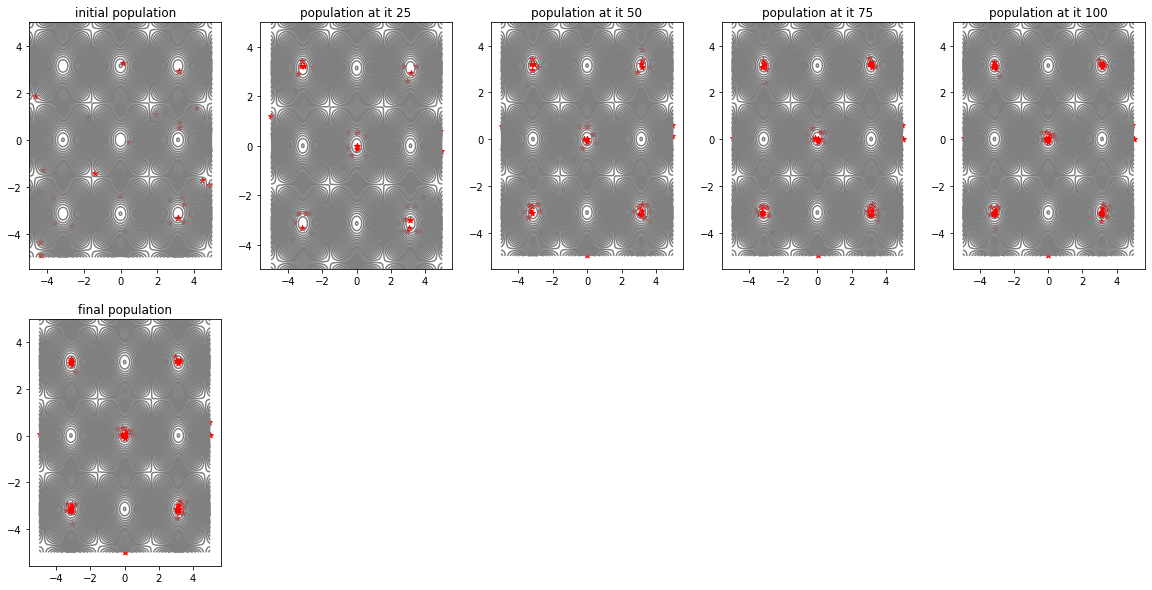

In [84]:
probMultimodal = ContinuousOptimization(2, -5,5, "evalGriewank")
cost, el, graphicPoints = CrowdingDE(probMultimodal,50,100,0.5,0.5)
FunctionPlot(probMultimodal, graphicPoints, start=-5, stop=5)

rendering figure 0 of 6
rendering figure 1 of 6
rendering figure 2 of 6
rendering figure 3 of 6
rendering figure 4 of 6
rendering figure 5 of 6


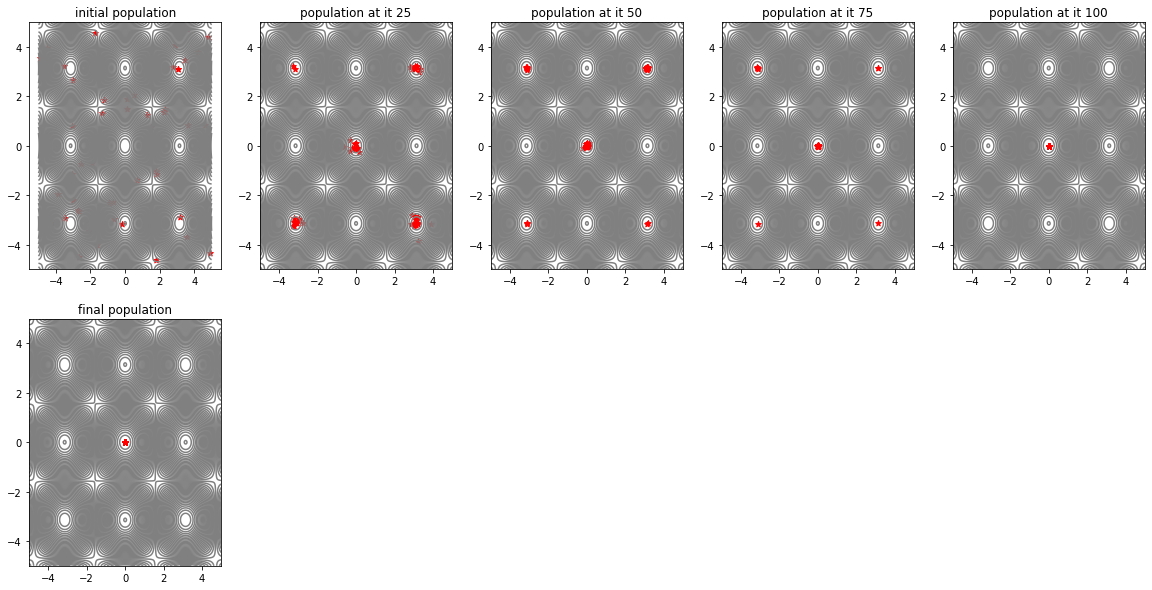

In [85]:
probMultimodal = ContinuousOptimization(2, -5,5, "evalGriewank")
cost, el, graphicPoints = DE(probMultimodal,50,100,0.5,0.5)
FunctionPlot(probMultimodal, graphicPoints, start=-5, stop=5)